In [1]:
!pip install -q mlflow nlp datasets openai

In [2]:
#imports
import pandas as pd
import gc
import re
import numpy as np
import torch
import transformers
from transformers import AutoModel, AutoTokenizer, TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification
from huggingface_hub import login
from torch import cuda, bfloat16
from datasets import load_dataset
from nlp import Dataset
from imblearn.over_sampling import RandomOverSampler
import datasets
from transformers import pipeline
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from openai import OpenAI
tqdm.pandas()

In [3]:
# set parameters
train_fraction = 0.7 # fraction of a dataset used for training (the rest used for validation)
num_train_epochs = 3 # epochs to train
batch_size = 16 # batch size for training and validation
warmup_steps = 50
weight_decay = 0.02
t5_model = "google-t5/t5-small"
output_dir = "./phishing-email-detection"

In [4]:
dataset = load_dataset("zefang-liu/phishing-email-dataset", trust_remote_code=True)
df = dataset['train'].to_pandas()
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
print(df.shape)
df.sample(5).T

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/18650 [00:00<?, ? examples/s]

(17539, 2)


,9422,16235,8637,16671,198
Email Text,freshest email - addresses - ( for the pro or ...,global ops task force week ending 9 / 29 this ...,enron / hpl actuals for 10 / 6 - 9 / 00 enron ...,"On Fri 02 Aug 2002 13:41, Colm Buckley wrote:>...",earnings calger $ 42 pastoria $ 7 q 2 & $ 10 q...
Email Type,Phishing Email,Safe Email,Safe Email,Safe Email,Safe Email


In [5]:
# create target
df['label'] = (df['Email Type']=="Phishing Email").astype(int)
df['title'] = df['Email Text']
df = df[['title', 'label']]

print(df.shape)
df.sample(20)

(17539, 2)


,title,label
11396,"On January 1st 2002, the European countries be...",1
2032,popular software at low low prices . bury veto...,1
18473,\n----- Original Message -----\nFrom: > People...,0
6694,do you know how much you can pocket after purc...,1
16234,I am somewhat puzzled by a phone call I (or ra...,0
17611,young wifes click here to be removed,1
14338,kindest attention kindest attention . this pro...,1
7783,"Of course, everyone knows that Owlman is a wor...",0
15243,your r _ x order is ready for refill share nut...,1
8881,"re : dec 13 dpr dear john , the following are ...",0


In [6]:
# drop null records
df.dropna(inplace=True)
df['label'].mean()

<ipython-input-6-17ea06fec25c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


0.37393089291823467

In [7]:
# random oversampling of minority class
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
print(df.shape)
del y_resampled
gc.collect()

(21960, 2)


36

In [8]:
medium_dataset = Dataset.from_pandas(df)
del df
gc.collect()

0

In [9]:
tokenizer = AutoTokenizer.from_pretrained(t5_model, use_fast=True, low_cpu_mem_usage=False)

# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

medium_dataset = medium_dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [10]:
# Dataset has a built in train test split method
medium_dataset = medium_dataset.train_test_split(test_size=1-train_fraction)
medium_dataset
medium_dataset.remove_column_("title") # remove the text column because we don't need to keep it in memory anymore

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad text in the tokenizer function with padding=True but dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
tokenizer.decode(medium_dataset['train'][0]['input_ids'])

'2 nd message - re : dec 2 super saturday interviewer confirmation please see the attached for interviewer information. shelly jones 11 / 28 / 2000 05 : 54 pm to : scott earnest / hou / ect @ ect, tim mckone / corp / enron @ enron, richard dimichele / enron communications @ enron communications, brandon neff / hou / ees @ ees, john j lavorato / corp / enron @ enron, guido caranti / enron _ development @ enron _ development, robert bailey / hou / ees @ ees, dixie yeck / enron communications @ enron communications, cheryl lipshutz / hou / ect @ ect, john godbold / hou / ect @ ect, chuck randall / hou / ees @ ees, michelle juden / hou / ees @ ees, mark reese / hou / ees @ ees, jim fallon / enron communications @ enron communications, sarah wesner / corp / enron @ enron, sylvia barnes / hou / ees @ ees, kirk neuner / enron communications @ enron communications, mari capestany / hou / ees @ ees, wayne perry / enron _ development @ enron _ development, john neslage / enron _ development @ en

# Loading and training model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    t5_model, num_labels=2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

model.config.id2label = {0: 'SAFE EMAIL', 1: 'PHISHING EMAIL'}

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

60.770306


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Select the correct logits if there are multiple outputs
    if isinstance(logits, tuple):
        logits = logits[0]  # Assuming the first element is the correct logits

    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Return all metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [16]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    eval_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    save_strategy='epoch',
    report_to="mlflow",  # log to mlflow
)

# Define the trainer, initiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=medium_dataset['train'],
    eval_dataset=medium_dataset['test'],
    data_collator=data_collator
)

In [17]:
# Get initial metrics
trainer.evaluate()

{'eval_loss': 0.825533390045166,
 'eval_model_preparation_time': 0.0033,
 'eval_accuracy': 0.49628168159052966,
 'eval_precision': 0.452262451510639,
 'eval_recall': 0.49628168159052966,
 'eval_f1': 0.35338602299510413,
 'eval_runtime': 65.7167,
 'eval_samples_per_second': 100.264,
 'eval_steps_per_second': 6.269}

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.012900,0.074848,0.003300,0.979967,0.979984,0.979967,0.979966
2,0.001100,0.059701,0.003300,0.986189,0.986202,0.986189,0.986189
3,0.537500,0.058489,0.003300,0.987251,0.987281,0.987251,0.987251


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


TrainOutput(global_step=2883, training_loss=0.12040703022571335, metrics={'train_runtime': 894.8447, 'train_samples_per_second': 51.532, 'train_steps_per_second': 3.222, 'total_flos': 6275629399946496.0, 'train_loss': 0.12040703022571335, 'epoch': 3.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.05848882719874382,
 'eval_model_preparation_time': 0.0033,
 'eval_accuracy': 0.9872514797389589,
 'eval_precision': 0.987281419121561,
 'eval_recall': 0.9872514797389589,
 'eval_f1': 0.9872510750716872,
 'eval_runtime': 40.6908,
 'eval_samples_per_second': 161.929,
 'eval_steps_per_second': 10.125,
 'epoch': 3.0}

# Visualisations

Number of evaluation loss points: 4


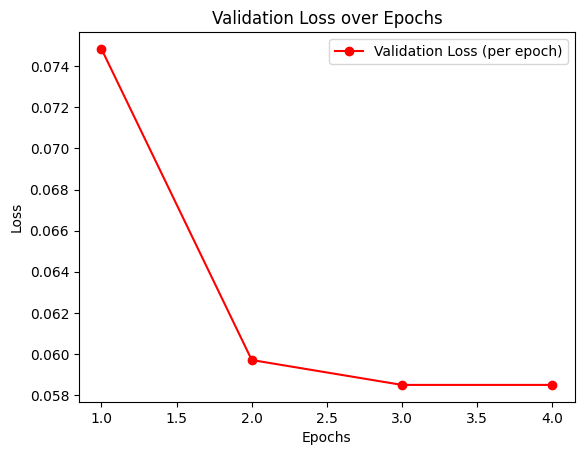

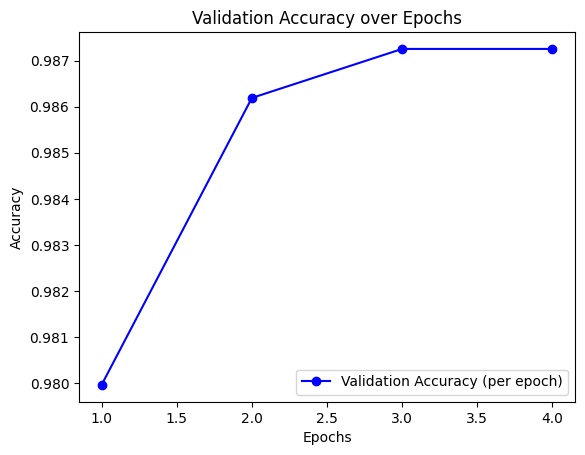

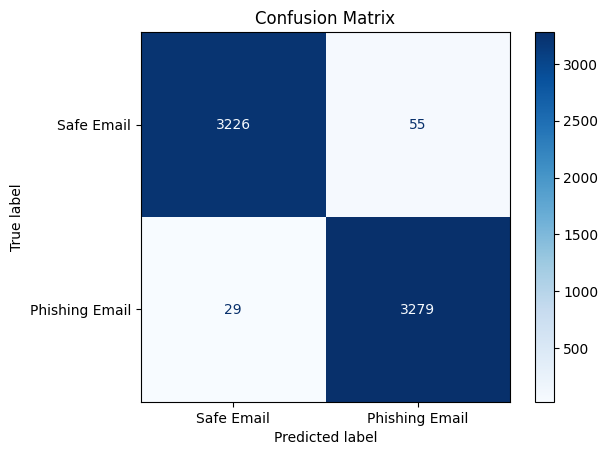

In [20]:
log_history = trainer.state.log_history

eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

print(f"Number of evaluation loss points: {len(eval_loss)}")

# Check how many evaluations happened
epochs_eval = range(1, len(eval_loss) + 1)

plt.plot(epochs_eval, eval_loss, 'ro-', label='Validation Loss (per epoch)')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs_eval, eval_accuracy, 'bo-', label='Validation Accuracy (per epoch)')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

predictions = trainer.predict(medium_dataset['test'])

if isinstance(predictions.predictions, tuple):
    logits = predictions.predictions[0]
else:
    logits = predictions.predictions

predicted_labels = np.argmax(logits, axis=-1)
true_labels = medium_dataset['test']['label']

class_names = ['Safe Email', 'Phishing Email']

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Saving the model and checking its performance with a sample

In [21]:
trainer.save_model()
tokenizer.save_vocabulary(save_directory=output_dir)

('./phishing-email-detection/spiece.model',)

In [22]:
# make a classification pipeline
pipe = pipeline("text-classification", output_dir, tokenizer=t5_model)
sample_title = '''Why do employees leave companies — analysis of IBM employee data'''
pipe(sample_title, top_k=None)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'SAFE EMAIL', 'score': 0.9454319477081299},
 {'label': 'PHISHING EMAIL', 'score': 0.054568078368902206}]

In [23]:
# use the upper-case version
sample_title2 = sample_title.upper()
pipe(sample_title2, top_k=None)

[{'label': 'PHISHING EMAIL', 'score': 0.5398445725440979},
 {'label': 'SAFE EMAIL', 'score': 0.4601554274559021}]

In [24]:
# more refined version
sample_title3 = '''Why do employees leave companies?'''
pipe(sample_title3, top_k=None)

[{'label': 'PHISHING EMAIL', 'score': 0.8965618014335632},
 {'label': 'SAFE EMAIL', 'score': 0.10343818366527557}]

In [25]:
# Initialize the OpenAI client
client = OpenAI(api_key="API_KEY")

# Function to validate email address format
def is_valid_email(email):
    return '@' in email and '.' in email

# Function to classify and extract email
def classify_and_extract_email(text, pipe, threshold=0.5):
    results = pipe(text, top_k=None)
    print("Classification results: ", results)
    for result in results:
        if result['label'] == 'PHISHING EMAIL' and result['score'] >= threshold:
            return result
    return results

# Function to generate a counter-response to phishing email using ChatGPT
def generate_counter_response(phishing_email_content):
    prompt = (
        "You are an expert in cybersecurity and email security."
        "Here is a phishing email:\n\n"
        f"{phishing_email_content}\n\n"
        "Craft a response to this phishing email that engages the sender."
        "Your goal is to gather more information about the sender or their intentions."
        "Ensure the response appears interested in the offer, but subtly aims to expose or trap the sender."
        "Avoid directly revealing that you are aware of the phishing attempt."
        "Make the response convincing and professional, encouraging further interaction that could reveal more about the sender’s motives."
    )

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
    )
    return print(response.choices[0].message.content)

# Function to save the phishing email to a CSV file
def save_to_csv(email, subject, content):
    output_file = Path("phishing_emails.csv")

    # Check if the file exists to write header only for the first time
    file_exists = output_file.exists()

    with open(output_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Email Address", "Subject", "Email Content"])  # Write header if the file is created first time
        writer.writerow([email, subject, content])

# Main program function to get email details and classify it
def main():
  while True:
    # Input email details from the user
    email_address = input("Enter the email address:")
    if not is_valid_email(email_address):
      print("Invalid email address! Please enter a valid email.")
      continue

    subject = input("Enter the subject:")
    email_content = input("Enter the email content:")

    if not email_address or not subject or not email_content:
        print("All fields must be filled!")
        continue

    # Classify the email content
    result = classify_and_extract_email(email_content, classification_pipe)

    if result['label'] == 'PHISHING EMAIL':
        # Generate a counter response using ChatGPT
        print(f"Phishing email detected! \nGenerated response:\n")
        response = generate_counter_response(email_content)

        # Save to CSV
        save_to_csv(email_address, subject, email_content)
        print("Phishing email information saved to CSV.")

    else:
      print("The email is classified as safe.")

    # Option to process another email or exit
    another = input("Do you want to process another email? (yes/no): ").lower()
    if another != 'yes':
      break

# Directory where the model and tokenizer are saved
output_dir = "phishing-email-detection"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Load the text-classification pipeline
classification_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Run the main program
if __name__ == "__main__":
    main()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Enter the email address:test@example.com
Enter the subject:Claim your free gift card!
Enter the email content:Click NOW on the link below to claim your FREE gift card!
Classification results:  [{'label': 'PHISHING EMAIL', 'score': 0.9996922016143799}, {'label': 'SAFE EMAIL', 'score': 0.000307777983834967}]
Phishing email detected! 
Generated response:

Subject: Re: Excited About My Free Gift Card!

Dear sender,

Thank you so much for your generous offer! I'm absolutely thrilled about the opportunity to receive a free gift card. However, before proceeding, I'm curious about a few things, if you'd be kind enough to indulge my queries.

Firstly, can I kindly ask what company you're representing? I've been getting various emails from different companies, and it has completely slipped my mind which promotional emails I've subscribed to due to the sheer volume.

Secondly, I'm keen to know more about the gift card. Which store or service is the gift card applicable to? Also wondering, what wo